In [16]:
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode
from darts.models import CatBoostModel, FourTheta, Prophet
from darts.metrics import mape
import optuna
from darts.utils.statistics import plot_residuals_analysis
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import constant_timeseries
import seaborn as sns

In [17]:
from darts.metrics import mape,mae,mse
from darts.timeseries import TimeSeries
#from darts.models import Prophet,CatBoostModel,FFT
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist,extract_trend_and_seasonality
from darts.utils.utils import SeasonalityMode
import logging
from darts.utils.utils import ModelMode
from darts.utils.utils import TrendMode
from darts.models import FourTheta, Prophet
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers import BoxCox

In [18]:
series = pd.read_csv("data/series_total.csv")
weekly_cases = pd.read_csv("data/weekly_cases.csv")

def train_test_splits(series, train_proportion_list):
    '''
    Funcao para dividir a serie temporal em treino e teste
    
    Parametros:
    
    *series: serie que sera particionada em treino e validacao.
    *train_proportion_list: Lista que define a proporcao do conjunto
    de treinamento. Ex: series_list = [0.8,0.5] significa primeiro conjunto 
    de treino com 80% dos dados totais e o segundo com 50% dos dados totais.
    '''
    partitions_dict = {'train': [], 'test': []}

    for i, train_proportion in enumerate(train_proportion_list):
        train_size = int(len(series) * train_proportion)
        train, test = series.split_before(train_size)
        partitions_dict['train'].append(train)
        partitions_dict['test'].append(test)

        print(f'Partition {i+1} - Train size: {len(train)}, Test size: {len(test)}, Total size: {len(train)+len(test)}')

    return partitions_dict

In [91]:
# 1. Converter a coluna de data para datetime
weekly_cases["Epi_Date"] = pd.to_datetime(weekly_cases["Epi_Date"])

# 2. Ordenar por data, se necessário
weekly_cases = weekly_cases.sort_values("Epi_Date")

# 3. Criar objeto TimeSeries com a coluna "Number"
ts_weekly_cases = TimeSeries.from_dataframe(weekly_cases, time_col="Epi_Date", value_cols="Number")


In [92]:
## Normalizando os dados

SRAG_scaler = Scaler()
srag_series_scaled = SRAG_scaler.fit_transform(ts_weekly_cases)

srag_train , srag_val = ts_weekly_cases.split_before(0.85)

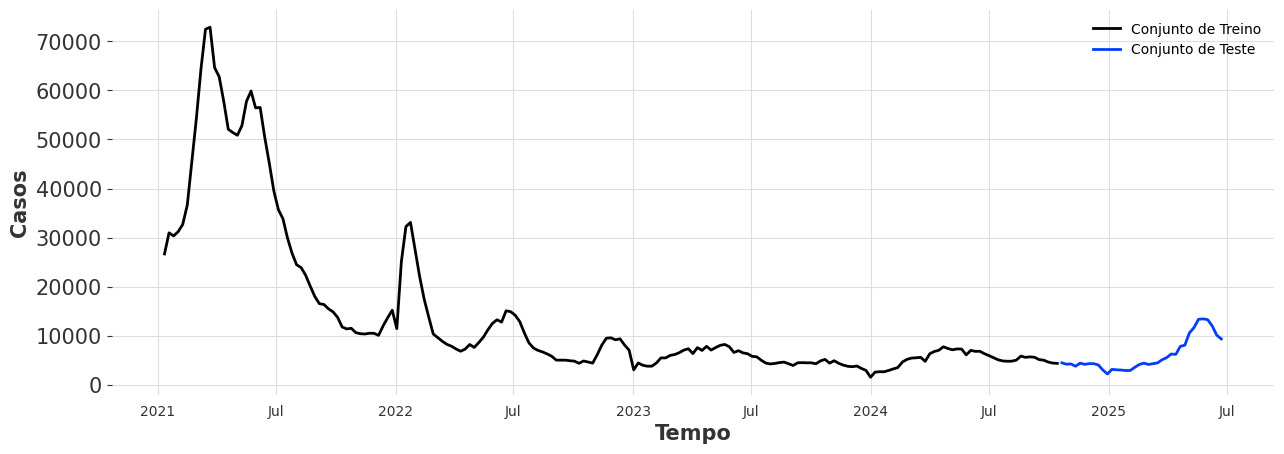

In [93]:
figure = plt.figure(figsize=(15, 5))
srag_train.plot(label = 'Conjunto de Treino')
srag_val.plot(label = 'Conjunto de Teste')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 15)
plt.xlabel('Tempo', fontsize = 15)
plt.ylabel('Casos', fontsize = 15)
plt.legend()
plt.show()

In [94]:
preds = best_model.predict(n=len(srag_val)+50, num_samples=100)
mape_pred = mape(srag_val,preds)
fig = plt.figure(figsize=(15,5))
srag_train.plot(label='Série original')
srag_val.plot()
preds.plot(label='Previsão')
plt.plot([],[],' ',label=f'MAPE: {round(mape_pred,2)}')
plt.legend()
plt.show()

ValueError: `num_samples > 1` is only supported for probabilistic models.


ValueError: `num_samples > 1` is only supported for probabilistic models.

In [22]:
def objective(trial):
    global model

    params = {
        "theta": trial.suggest_int("theta", 0, 5),
        "seasonality_period": trial.suggest_int("seasonality_period", 15,80),
        "season_mode": trial.suggest_categorical("season_mode", [
            SeasonalityMode.ADDITIVE,
            SeasonalityMode.MULTIPLICATIVE
        ]),
        "model_mode": trial.suggest_categorical("model_mode", [
            ModelMode.ADDITIVE,
            ModelMode.MULTIPLICATIVE
        ]),
        "trend_mode": trial.suggest_categorical("trend_mode", [
            TrendMode.LINEAR,
            TrendMode.EXPONENTIAL
        ])
    }

    model = FourTheta(**params)
    model.fit(srag_train)
    predictions = model.predict(len(srag_val))

    return mape(srag_val, predictions)

In [95]:
from darts.utils.utils import SeasonalityMode

def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 510, callbacks = [callback])

[I 2025-07-11 07:09:08,720] A new study created in memory with name: no-name-c6da443e-30ea-4ee9-bb5d-200cb84ae638
C:\Python312\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains SeasonalityMode.ADDITIVE which is of type SeasonalityMode.
  warnings.warn(message)
C:\Python312\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains SeasonalityMode.MULTIPLICATIVE which is of type SeasonalityMode.
  warnings.warn(message)
C:\Python312\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
C:\Python312\Lib\site-packages\optuna\di

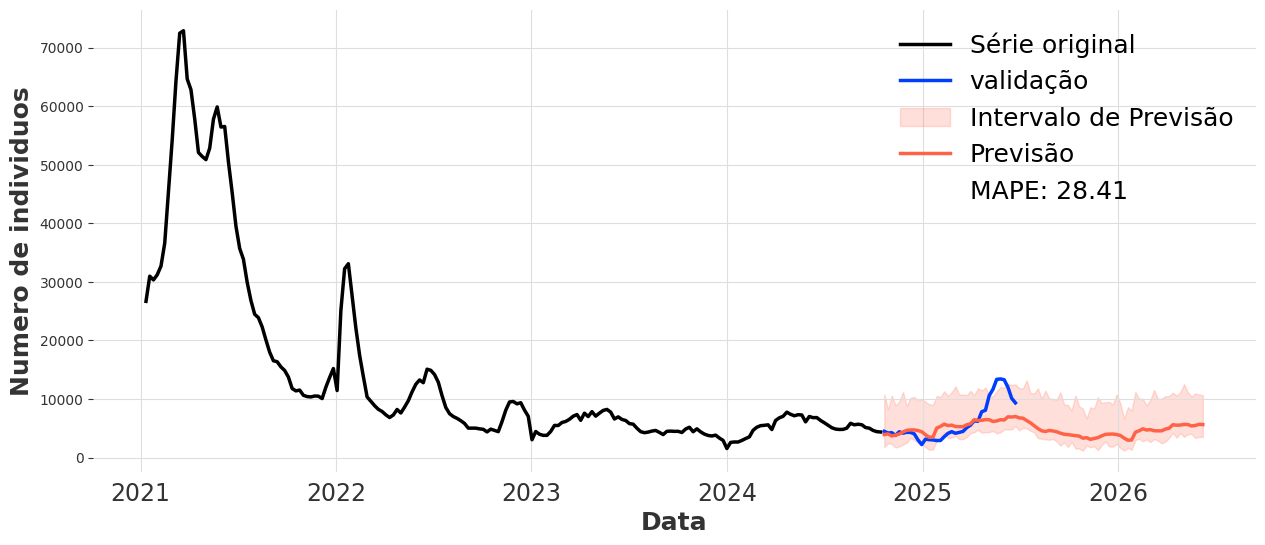

In [111]:
preds = best_model.predict(n=len(srag_val)+50)
mape_pred = mape(srag_val,preds)
fig = plt.figure(figsize=(15,6))
srag_train.plot(label='Série original', linewidth=2.5)
srag_val.plot(label='validação',linewidth=2.5)
plt.fill_between(df_pred_mean.index,df_pred_lo["lower"],df_pred_mean["mean"],label='Intervalo de Previsão',color='tomato',alpha=0.2)
preds.plot(label='Previsão', color='tomato', linewidth=2.5)
plt.plot([],[],' ',label=f'MAPE: {round(mape_pred,2)}')
plt.legend(fontsize=18)
plt.xlabel("Data", fontsize=18)
plt.ylabel("Numero de individuos", fontsize=18)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 10)
plt.show()

In [111]:
preds_df = preds.pd_dataframe()
preds_df.to_csv("data/preds_theta.csv")

In [98]:
import joblib
import os

# Cria a pasta se não existir
os.makedirs("modelos", exist_ok=True)

# Salvar o modelo
joblib.dump(best_model, "modelos/theta_model_joblib.pkl")

['modelos/theta_model_joblib.pkl']

In [99]:
preds = pd.read_csv("data/preds_theta.csv")

In [100]:
preds

,Epi_Date,Number
0,2024-10-21,3914.554043
1,2024-10-28,3749.876036
2,2024-11-04,3628.552288
3,2024-11-11,3719.710675
4,2024-11-18,3699.188968
...,...,...
81,2026-05-11,7087.879189
82,2026-05-18,6458.903057
83,2026-05-25,5618.020769
84,2026-06-01,5688.744324


In [101]:
from darts.metrics import mape

# Previsão no treino
train_pred = best_model.predict(len(srag_val))
residuals = (srag_val - train_pred).values().flatten()

from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from copy import deepcopy
import numpy as np
import pandas as pd

n_bootstrap = 100
forecast_len = len(srag_val) + 50
bootstrap_preds = []

# Fazer uma previsão base
pred_base = best_model.predict(forecast_len)
pred_values = pred_base.values().flatten()
time_index = pred_base.time_index  # salvar índice temporal

# Gerar múltiplas previsões com ruído adicionado
for _ in range(n_bootstrap):
    noise = np.random.choice(residuals, size=forecast_len, replace=True)
    noisy_values = pred_values + noise
    ts_noisy = TimeSeries.from_times_and_values(time_index, noisy_values.reshape(-1, 1))
    bootstrap_preds.append(ts_noisy)

# Converter previsões para DataFrames
df_preds = pd.DataFrame(
    data=np.column_stack([ts.values().flatten() for ts in bootstrap_preds]),
    index=time_index  # usa o índice da previsão original
)

# Calcular estatísticas
mean_vals = df_preds.mean(axis=1)
lower_vals = df_preds.quantile(0.1, axis=1)
upper_vals = df_preds.quantile(0.9, axis=1)

# Criar TimeSeries a partir dos resultados
pred_mean = TimeSeries.from_times_and_values(time_index, mean_vals.values.reshape(-1, 1))
pred_lo = TimeSeries.from_times_and_values(time_index, lower_vals.values.reshape(-1, 1))
pred_hi = TimeSeries.from_times_and_values(time_index, upper_vals.values.reshape(-1, 1))

In [102]:
from darts.metrics import mape

# Se necessário, ajuste o slice para bater com o tamanho da série de validação
mape_pred = mape(srag_val, pred_mean.slice_intersect(srag_val))

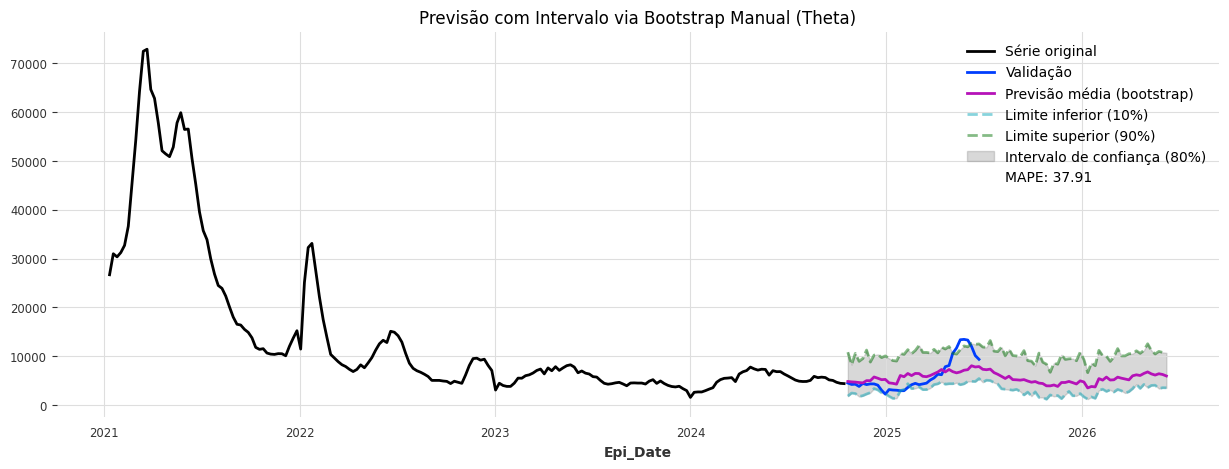

In [103]:
fig = plt.figure(figsize=(15, 5))

srag_train.plot(label='Série original')
srag_val.plot(label='Validação')
pred_mean.plot(label='Previsão média (bootstrap)')
pred_lo.plot(label='Limite inferior (10%)', linestyle='--', alpha=0.5)
pred_hi.plot(label='Limite superior (90%)', linestyle='--', alpha=0.5)

plt.fill_between(
    pred_lo.time_index,
    pred_lo.values().flatten(),
    pred_hi.values().flatten(),
    color='gray',
    alpha=0.3,
    label='Intervalo de confiança (80%)'
)

plt.plot([], [], ' ', label=f'MAPE: {round(mape_pred, 2)}')
plt.legend()
plt.title("Previsão com Intervalo via Bootstrap Manual (Theta)")
plt.grid(True)
plt.show()

<TimeSeries (DataArray) (Epi_Date: 86, component: 1, sample: 1)> Size: 688B
array([[[10810.49016554]],

       [[ 8253.7304379 ]],

       [[10568.81579393]],

       [[ 8937.87431588]],

       [[ 9520.36984745]],

       [[11249.25230619]],

       [[ 8786.4824029 ]],

       [[10205.08101517]],

       [[10355.18990026]],

       [[ 9703.14152022]],

...

       [[10501.41158637]],

       [[11099.22064133]],

       [[10571.36106339]],

       [[11182.73053326]],

       [[12536.87626463]],

       [[11143.49561589]],

       [[10439.8192352 ]],

       [[10973.72511363]],

       [[10758.2701647 ]],

       [[10675.62940081]]])
Coordinates:
  * Epi_Date   (Epi_Date) datetime64[ns] 688B 2024-10-21 ... 2026-06-08
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [110]:
df_pred_mean = pd.DataFrame({
    "mean": pred_hi.values().flatten()
}, index=pred_mean.time_index)

df_pred_lo = pd.DataFrame({
    "lower": pred_lo.values().flatten()
}, index=pred_lo.time_index)

In [105]:
df_pred_lo

,lower
Epi_Date,
2024-10-21,1814.741365
2024-10-28,2440.521956
2024-11-04,2342.527476
2024-11-11,1732.095621
2024-11-18,1908.081709
...,...
2026-05-11,4001.274790
2026-05-18,4048.502755
2026-05-25,3361.436975


## Plotando Resultados

In [124]:
train_data_lstm = pd.read_csv("data/train_data_lstm.csv", parse_dates=["Data"], index_col="Data")
test_data_lstm = pd.read_csv("data/test_data_lstm.csv", parse_dates=["Data"], index_col="Data")
df_future_lstm = pd.read_csv("data/df_future_lstm.csv", parse_dates=["Data"])
pred = pd.read_csv("pred_prophet.csv")
patchtst = pd.read_csv("patchtst.csv")

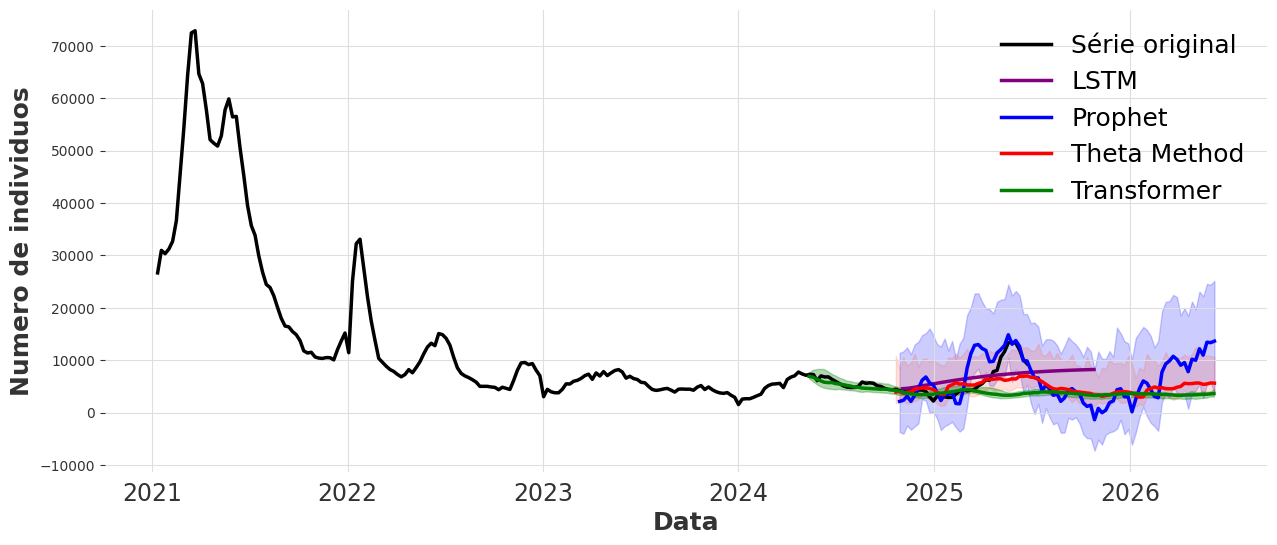

In [139]:
fig = plt.figure(figsize=(15,6))
ts_weekly_cases.plot(label='Série original', linewidth=2.5)

## LSTM
plt.plot(df_future_lstm["Data"], df_future_lstm["Previsao de casos"], color="purple", linewidth=2.5,  label="LSTM")

## Prophet
pred["Epi_Date"] = pd.to_datetime(pred["Epi_Date"])
plt.plot(pred["Epi_Date"], pred["mean"], color="blue",linewidth=2.5, label="Prophet")
plt.fill_between(pred["Epi_Date"], pred["lower"], pred["upper"],color="blue", alpha=0.2)

# theta method
plt.fill_between(df_pred_mean.index,df_pred_lo["lower"],df_pred_mean["mean"],color='tomato',alpha=0.2)
preds.plot(label='Theta Method', color='red', linewidth=2.5)

#transformer
patchtst['Date'] = pd.to_datetime(patchtst['Date'])
plt.plot(patchtst['Date'],patchtst['PatchTST-median'],label='Transformer',color = 'green', linewidth=2.5)
plt.fill_between(patchtst['Date'],patchtst['PatchTST-lo-80'],patchtst['PatchTST-hi-80'],color='green',alpha=0.3)

plt.legend(fontsize=18)
plt.xlabel("Data", fontsize=18)
plt.ylabel("Numero de individuos", fontsize=18)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 10)
plt.show()